# Heart Disease Prediction

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
# from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from collections import Counter
import imblearn
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

## Reading Dataset

In [2]:
# Load the dataset (adjust the path)
df = pd.read_csv("heart_2022_no_nans.csv")

In [3]:
# Basic overview
print(df.shape)
print(df.columns.tolist())
df.head()

(246022, 40)
['State', 'Sex', 'GeneralHealth', 'PhysicalHealthDays', 'MentalHealthDays', 'LastCheckupTime', 'PhysicalActivities', 'SleepHours', 'RemovedTeeth', 'HadHeartAttack', 'HadAngina', 'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD', 'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis', 'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty', 'DifficultyConcentrating', 'DifficultyWalking', 'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus', 'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory', 'HeightInMeters', 'WeightInKilograms', 'BMI', 'AlcoholDrinkers', 'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap', 'HighRiskLastYear', 'CovidPos']


,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,Alabama,Female,Very good,4.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.60,71.67,27.99,No,No,Yes,Yes,"Yes, received Tdap",No,No
1,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,Yes,6.0,None of them,No,...,1.78,95.25,30.13,No,No,Yes,Yes,"Yes, received tetanus shot but not sure what type",No,No
2,Alabama,Male,Very good,0.0,0.0,Within past year (anytime less than 12 months ...,No,8.0,"6 or more, but not all",No,...,1.85,108.86,31.66,Yes,No,No,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
3,Alabama,Female,Fair,5.0,0.0,Within past year (anytime less than 12 months ...,Yes,9.0,None of them,No,...,1.70,90.72,31.32,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,Yes
4,Alabama,Female,Good,3.0,15.0,Within past year (anytime less than 12 months ...,Yes,5.0,1 to 5,No,...,1.55,79.38,33.07,No,No,Yes,Yes,"No, did not receive any tetanus shot in the pa...",No,No


## Check Missing Values

In [4]:
df.isna().sum().sort_values(ascending = False).head()

,0
State,0
Sex,0
GeneralHealth,0
PhysicalHealthDays,0
MentalHealthDays,0


## Drop certain features and rows

In [5]:
df['HeartDisease'] = (
    df[['HadHeartAttack', 'HadAngina']]
    .apply(lambda col: col.map({'Yes': 1, 'No': 0}))
    .any(axis=1).astype(int)
)
df.drop(columns=['HadHeartAttack', 'HadAngina'], inplace=True)
df.drop(columns=['ChestScan', 'State'], inplace=True) # Drop ChestScan as its possible cheating, and State for more general model
print(df.shape)
print(df.columns)

(246022, 37)
Index(['Sex', 'GeneralHealth', 'PhysicalHealthDays', 'MentalHealthDays',
       'LastCheckupTime', 'PhysicalActivities', 'SleepHours', 'RemovedTeeth',
       'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
       'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'RaceEthnicityCategory', 'AgeCategory',
       'HeightInMeters', 'WeightInKilograms', 'BMI', 'AlcoholDrinkers',
       'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap',
       'HighRiskLastYear', 'CovidPos', 'HeartDisease'],
      dtype='object')


## Check target class imbalance

In [6]:
df['HeartDisease'].value_counts(normalize=True)

,proportion
HeartDisease,
0,0.912138
1,0.087862


## Feature Construction

### Informative Feature Summary

In [7]:
# Summarize physical and cognitive impairment
disability_cols = ['DifficultyWalking', 'DifficultyConcentrating',
                   'DifficultyDressingBathing', 'DifficultyErrands']
df['DisabilityScore'] = df[disability_cols].apply(lambda row: sum(row == 'Yes'), axis=1)

### Check for Outliers
- No significant ones

(246022, 8)


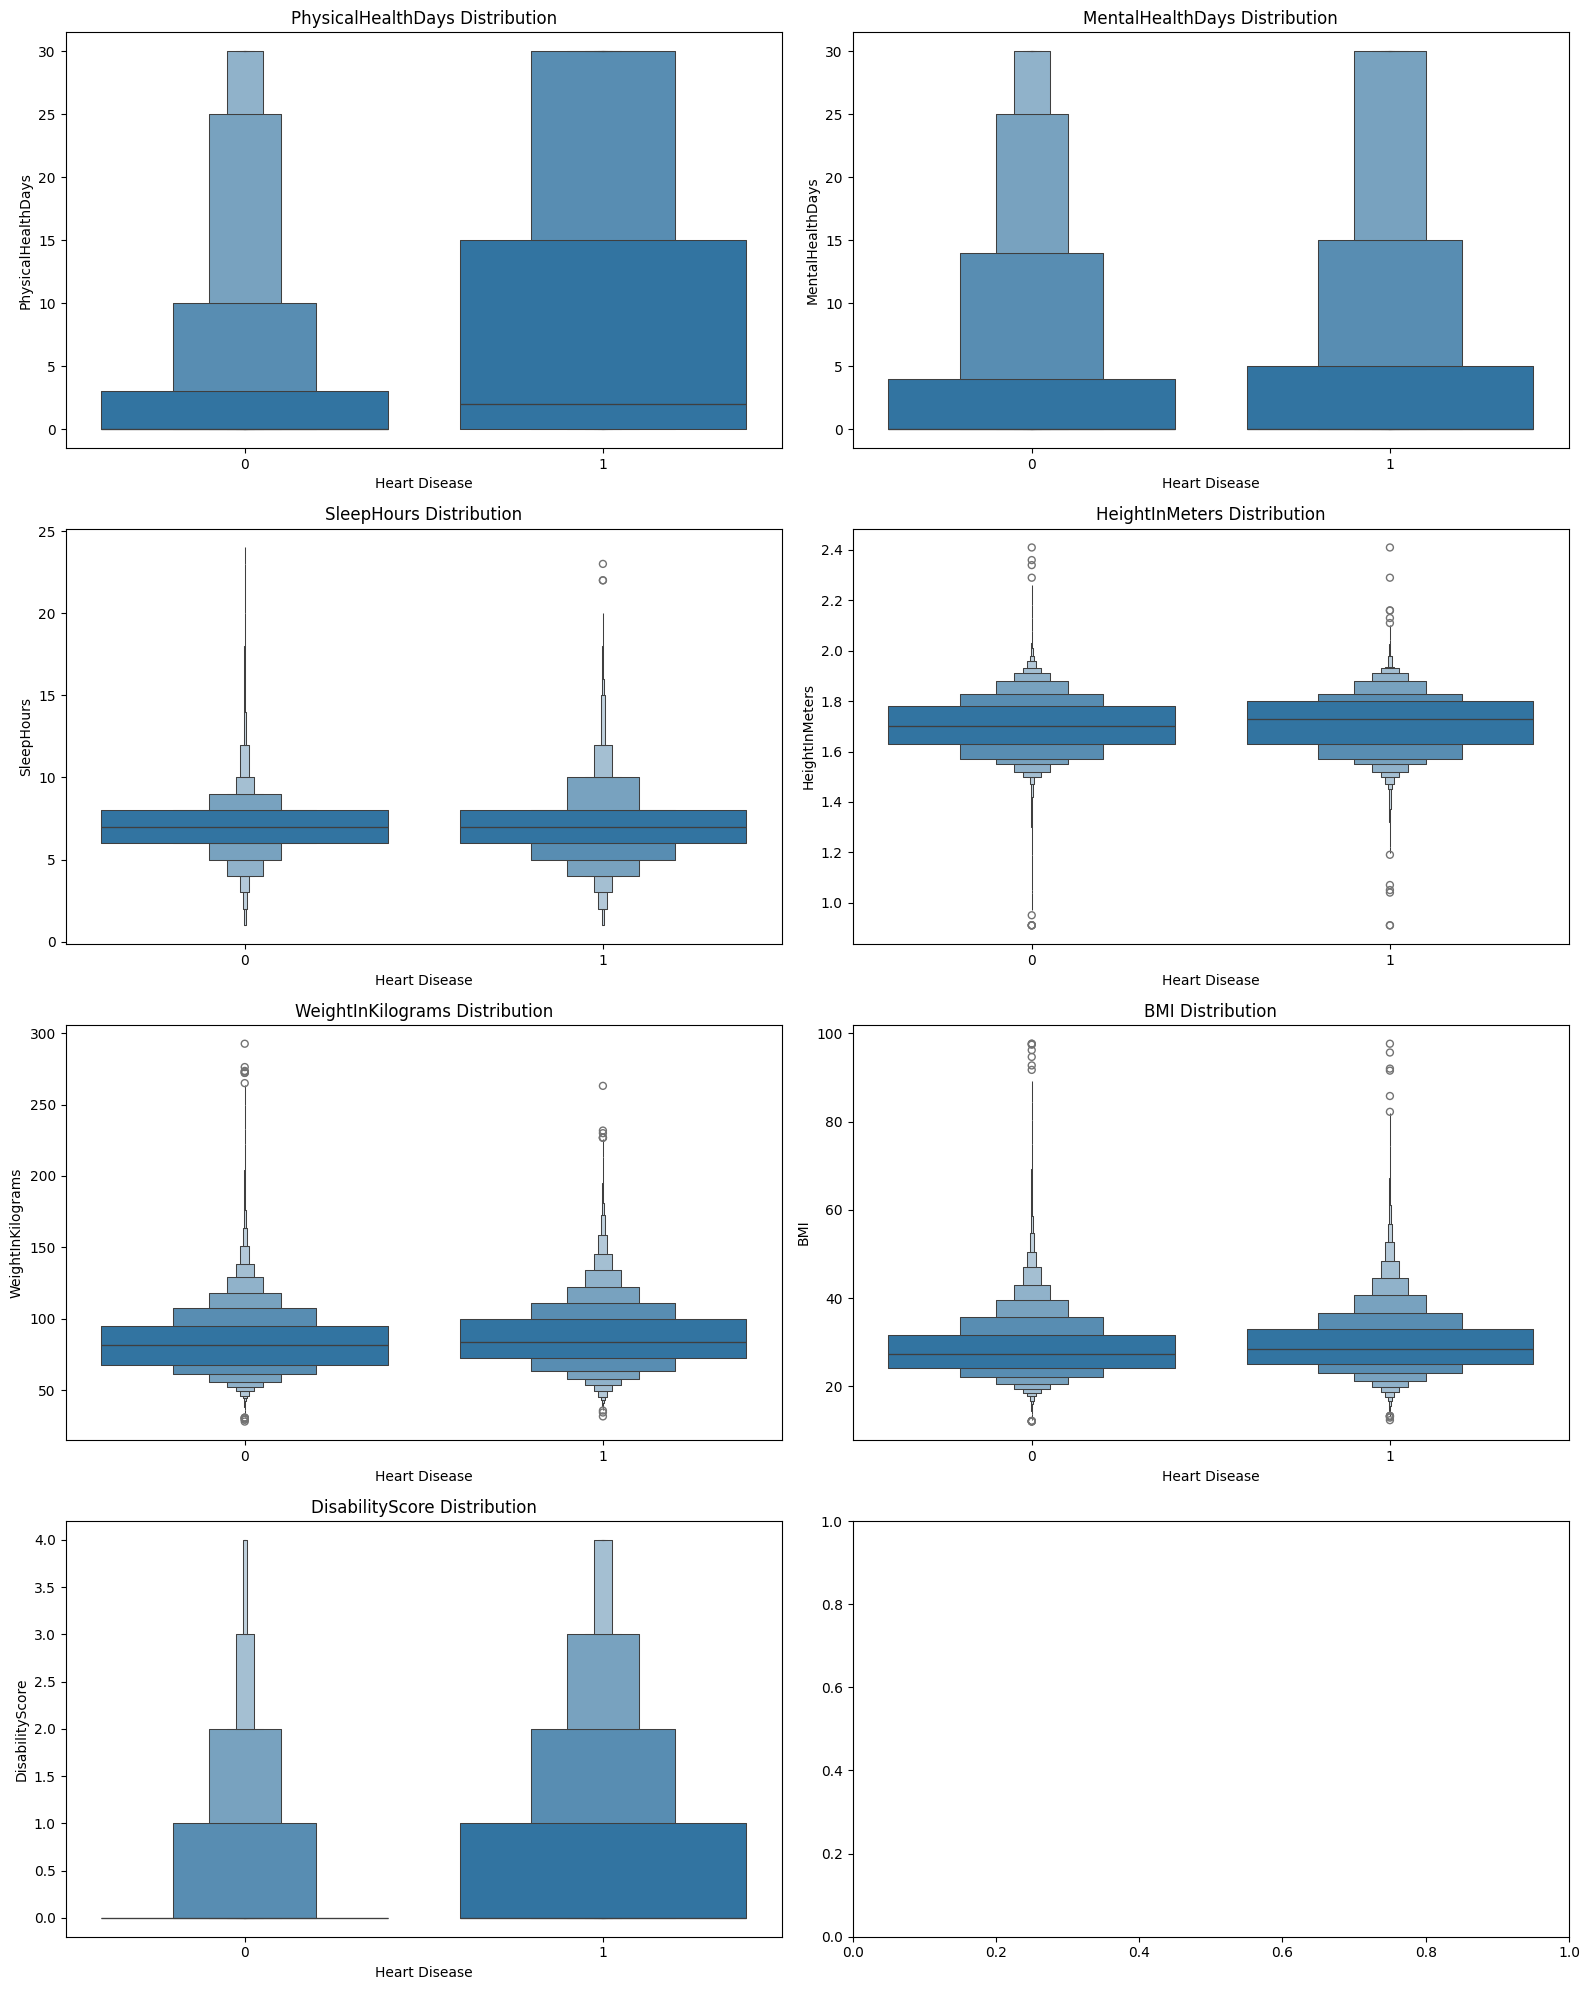

In [8]:
df_num = df.select_dtypes(include = ['float64', 'int64'])
print(df_num.shape)
df_num.head()

fig, axes = plt.subplots(nrows=len(df_num.columns) // 2, ncols=2, figsize=(16, 20))

for idx, column in enumerate(df_num.drop(columns = 'HeartDisease')):
    row_idx = idx // 2
    col_idx = idx % 2

    sns.boxenplot( x='HeartDisease' , y= column , data=df, ax=axes[row_idx, col_idx])

    axes[row_idx, col_idx].set_xlabel("Heart Disease")
    axes[row_idx, col_idx].set_ylabel(column)
    axes[row_idx, col_idx].set_title(f"{column} Distribution")

plt.tight_layout()
plt.show()

### Correlation Check

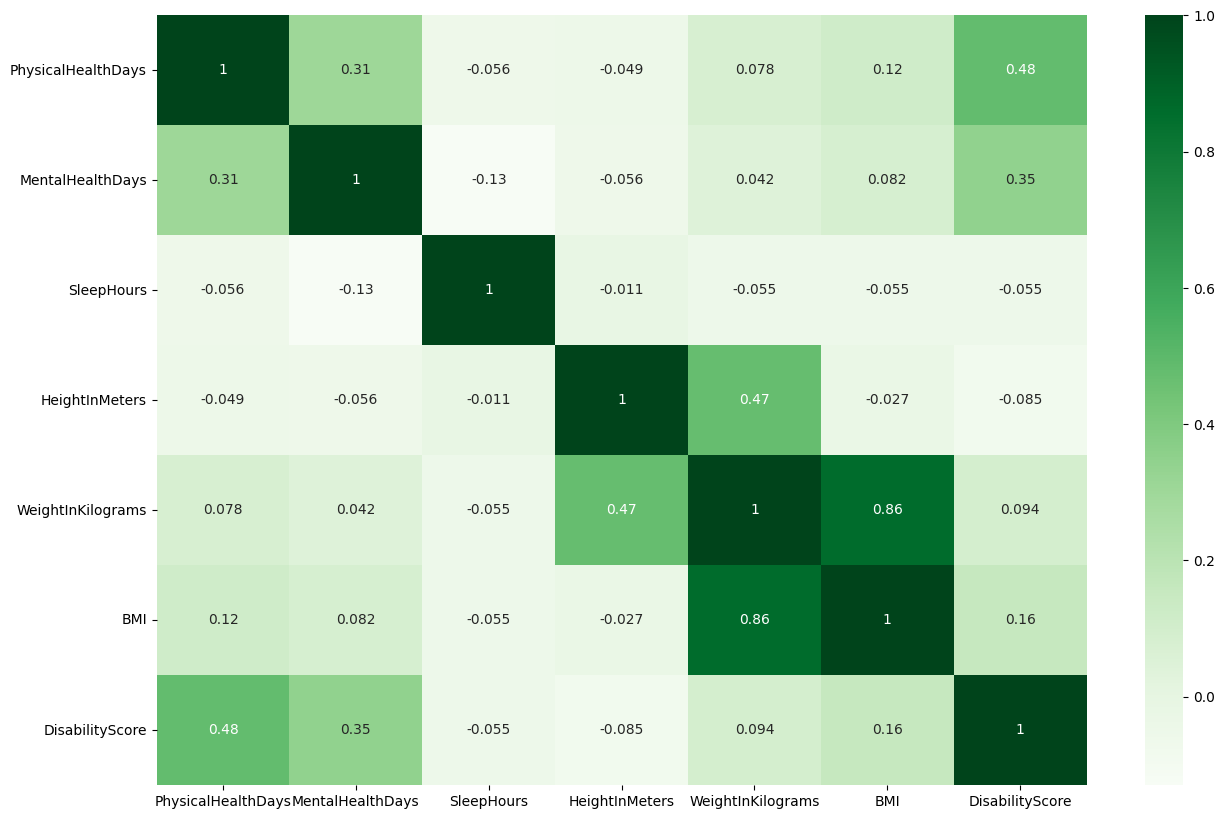

In [9]:
corr = df_num.drop(columns= 'HeartDisease').corr() # get the Pearson correlation matrix
fig , ax = plt.subplots(figsize=(15 , 10))
sns.heatmap(corr ,annot= True , ax=ax , cmap= 'Greens');

In [10]:
print(f"Correlation between WeightInKilograms and BMI :{df['WeightInKilograms'].corr(df['BMI'])}")
print(f"Correlation between WeightInKilograms and the target :{df['WeightInKilograms'].corr(df['HeartDisease'])}")
print(f"Correlation between BMI and the target :{df['BMI'].corr(df['HeartDisease'])}")

Correlation between WeightInKilograms and BMI :0.859313232736645
Correlation between WeightInKilograms and the target :0.05038453987386603
Correlation between BMI and the target :0.04500233612614124


Since BMI is derived from weight and height, it would make sense to drop WeightInKilograms, but I am not going to as personally I know that BMI is often not the best indicator hence I would like to keep the weight and height.

### Categorical Binning
Potentially better performance if non-linear feature patterns exist for linear models. Gives interpretability to tree-based models. Will still be keeping original columns, making my dataset more general for different models.

In [11]:
# sleep category for threshold emphasis
def sleep_category(hours):
    if hours < 5:
        return 'VeryShort'
    elif 5 <= hours < 7:
        return 'Short'
    elif 7 <= hours <= 9:
        return 'Optimal'
    else:
        return 'Long'

df['SleepCategory'] = df['SleepHours'].apply(sleep_category)

In [12]:
def bmi_category(bmi): # interpretability
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal'
    elif 25 <= bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

df['BMICategory'] = df['BMI'].apply(bmi_category)

### Normalise Numerical Values
- moved to pipeline

In [13]:
# from sklearn.preprocessing import StandardScaler

# numeric_cols = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours',
#                 'HeightInMeters', 'WeightInKilograms', 'BMI']

# # numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
# scaler = StandardScaler()
# df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

### Ordinal and One-hot Encoding

In [14]:
# Categorical columns to encode
ordinal_cols = ['SleepCategory', 'BMICategory', 'GeneralHealth', 'LastCheckupTime', 'AgeCategory']

# Map ordinal values
ord_sleep = ['VeryShort',
               'Short',
               'Optimal',
               'Long']
ord_bmi = ['Underweight',
            'Normal',
            'Overweight',
            'Obese']
ord_health = ['Poor', 'Fair', 'Good', 'Very good', 'Excellent']
ord_checkup = ['Within past year (anytime less than 12 months ago)',
               'Within past 2 years (1 year but less than 2 years ago)',
               'Within past 5 years (2 years but less than 5 years ago)',
               '5 or more years ago']
ord_age = ['Age 18 to 24', 'Age 25 to 29', 'Age 30 to 34', 'Age 35 to 39',
           'Age 40 to 44', 'Age 45 to 49', 'Age 50 to 54', 'Age 55 to 59',
           'Age 60 to 64', 'Age 65 to 69', 'Age 70 to 74', 'Age 75 to 79',
           'Age 80 or older']

# Apply ordinal encoding
df['SleepCategory'] = df['SleepCategory'].map({val: i for i, val in enumerate(ord_sleep)})
df['BMICategory'] = df['BMICategory'].map({val: i for i, val in enumerate(ord_bmi)})
df['GeneralHealth'] = df['GeneralHealth'].map({val: i for i, val in enumerate(ord_health)})
df['LastCheckupTime'] = df['LastCheckupTime'].map({val: i for i, val in enumerate(ord_checkup)})
df['AgeCategory'] = df['AgeCategory'].map({val: i for i, val in enumerate(ord_age)})

In [15]:
# One-hot encode nominal categorical variables
nominal_cols = df.select_dtypes(include=['object']).columns.difference(ordinal_cols)
df = pd.get_dummies(df, columns=nominal_cols, drop_first=True)

In [16]:
print(df.shape)
print(df.columns)
df.head()

(246022, 54)
Index(['GeneralHealth', 'PhysicalHealthDays', 'MentalHealthDays',
       'LastCheckupTime', 'SleepHours', 'AgeCategory', 'HeightInMeters',
       'WeightInKilograms', 'BMI', 'HeartDisease', 'DisabilityScore',
       'SleepCategory', 'BMICategory', 'AlcoholDrinkers_Yes',
       'BlindOrVisionDifficulty_Yes',
       'CovidPos_Tested positive using home test without a health professional',
       'CovidPos_Yes', 'DeafOrHardOfHearing_Yes',
       'DifficultyConcentrating_Yes', 'DifficultyDressingBathing_Yes',
       'DifficultyErrands_Yes', 'DifficultyWalking_Yes',
       'ECigaretteUsage_Not at all (right now)',
       'ECigaretteUsage_Use them every day',
       'ECigaretteUsage_Use them some days', 'FluVaxLast12_Yes',
       'HIVTesting_Yes', 'HadArthritis_Yes', 'HadAsthma_Yes', 'HadCOPD_Yes',
       'HadDepressiveDisorder_Yes',
       'HadDiabetes_No, pre-diabetes or borderline diabetes',
       'HadDiabetes_Yes',
       'HadDiabetes_Yes, but only during pregnancy (female)

,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,SleepHours,AgeCategory,HeightInMeters,WeightInKilograms,BMI,HeartDisease,...,"RemovedTeeth_6 or more, but not all",RemovedTeeth_All,RemovedTeeth_None of them,Sex_Male,SmokerStatus_Current smoker - now smokes some days,SmokerStatus_Former smoker,SmokerStatus_Never smoked,"TetanusLast10Tdap_Yes, received Tdap","TetanusLast10Tdap_Yes, received tetanus shot but not sure what type","TetanusLast10Tdap_Yes, received tetanus shot, but not Tdap"
0,3,4.0,0.0,0,9.0,9,1.60,71.67,27.99,0,...,False,False,True,False,False,True,False,True,False,False
1,3,0.0,0.0,0,6.0,10,1.78,95.25,30.13,0,...,False,False,True,True,False,True,False,False,True,False
2,3,0.0,0.0,0,8.0,11,1.85,108.86,31.66,0,...,True,False,False,True,False,True,False,False,False,False
3,1,5.0,0.0,0,9.0,12,1.70,90.72,31.32,0,...,False,False,True,False,False,False,True,False,False,False
4,2,3.0,15.0,0,5.0,12,1.55,79.38,33.07,0,...,False,False,False,False,False,False,True,False,False,False


### Normalise Numerical Features

In [17]:
numeric_cols = ['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours',
                'HeightInMeters', 'WeightInKilograms', 'BMI'] # because I've already did one hot encoding, dont want to normalise others

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols)
    ],
    remainder='passthrough' # IMPORTANT! REMAINING ENCODING COLUMNS PASS THROUGH
)

In [18]:
# columns_to_check = ['HeightInMeters']

# for col in columns_to_check:
#     print(f"\nUnique values in '{col}':")
#     print(df[col].unique())

## Initial Feature selection

### Univariate feature selection - Using Mutual Information

In [19]:
# Separate target and features
X = df.drop(columns=['HeartDisease'])
y = df['HeartDisease']

selector = SelectKBest(score_func=mutual_info_classif, k='all')
X_selected = selector.fit_transform(X, y)

scores = selector.scores_
feature_scores = pd.Series(scores, index=X.columns).sort_values(ascending=False)

print(feature_scores)

RemovedTeeth_None of them                                                 0.051305
PhysicalActivities_Yes                                                    0.049334
SmokerStatus_Never smoked                                                 0.047803
RaceEthnicityCategory_White only, Non-Hispanic                            0.045054
AlcoholDrinkers_Yes                                                       0.041808
FluVaxLast12_Yes                                                          0.038142
GeneralHealth                                                             0.037666
AgeCategory                                                               0.034853
PneumoVaxEver_Yes                                                         0.033704
Sex_Male                                                                  0.032973
HadArthritis_Yes                                                          0.026989
SleepCategory                                                             0.024530
Diff

Decided not to remove any features yet despite some having low MI scores (e.g. HadDiabetes, BMI, etc), they seemed potentially important and I did not want to make any early decisions.

## Model Setup and Cross-Validation

### Training & Evaluation

In [20]:
# Separate target and features
X = df.drop(columns=['HeartDisease'])
y = df['HeartDisease']

In [21]:
models = {
    "Naive Bayes": (
        GaussianNB(),
        {'var_smoothing': list(np.logspace(-4, 0, 3))}
    ),
    "Decision Tree": (
        DecisionTreeClassifier(class_weight='balanced', random_state=42),
        {'max_depth': [5, 10, 15]}
    ),
    "Random Forest": (
        RandomForestClassifier(class_weight='balanced', random_state=42),
        {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15]}
    )
}

# Stratified 5-fold CV (Outer Loop)
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

In [22]:
scoring_metrics = {
    'accuracy': accuracy_score,
    'precision': lambda y_true, y_pred: precision_score(y_true, y_pred),
    'recall': lambda y_true, y_pred: recall_score(y_true, y_pred),
    'f1': lambda y_true, y_pred: f1_score(y_true, y_pred),
    'precision_macro': lambda y_true, y_pred: precision_score(y_true, y_pred, average='macro'),
    'recall_macro': lambda y_true, y_pred: recall_score(y_true, y_pred, average='macro'),
    'f1_macro': lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro'),
    'precision_weighted': lambda y_true, y_pred: precision_score(y_true, y_pred, average='weighted'),
    'recall_weighted': lambda y_true, y_pred: recall_score(y_true, y_pred, average='weighted'),
    'f1_weighted': lambda y_true, y_pred: f1_score(y_true, y_pred, average='weighted'),
}

# scoring = {
#     'accuracy': make_scorer(accuracy_score),
#     'precision': make_scorer(precision_score, pos_label=1),
#     'recall': make_scorer(recall_score, pos_label=1),
#     'f1': make_scorer(f1_score, pos_label=1),
# }

In [23]:
for name, (model, param_grid) in models.items():
    print(f"\nModel: {name}")
    all_scores = {metric: [] for metric in scoring_metrics}
    best_params_list = []

    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipeline = ImbPipeline([
            ('preprocessor', preprocessor),
            ('clf', model),
        ])

        grid = GridSearchCV(
            estimator=pipeline,
            param_grid={'clf__' + k: v for k, v in param_grid.items()},
            cv=inner_cv,
            scoring='f1',
            n_jobs=-1
        )

        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        best_params_list.append(grid.best_params_)

        y_pred = best_model.predict(X_test)

        for metric, func in scoring_metrics.items():
            score = func(y_test, y_pred)
            all_scores[metric].append(score)

        print(f"  Fold {fold} Accuracy: {accuracy_score(y_test, y_pred):.4f}")

    print("\n=== Final Performance ===")
    for metric in scoring_metrics:
        scores = all_scores[metric]
        print(f"{metric.capitalize()}: {np.mean(scores)*100:.2f}% ± {np.std(scores)*100:.2f}%")

    print("\nBest Hyperparameters in each fold:")
    for i, params in enumerate(best_params_list, 1):
        print(f"  Fold {i}: {params}")


Model: Naive Bayes
  Fold 1 Accuracy: 0.8587
  Fold 2 Accuracy: 0.8598
  Fold 3 Accuracy: 0.8593
  Fold 4 Accuracy: 0.8618
  Fold 5 Accuracy: 0.8570

=== Final Performance ===
Accuracy: 85.93% ± 0.15%
Precision: 29.07% ± 0.51%
Recall: 41.75% ± 0.79%
F1: 34.27% ± 0.58%
Precision_macro: 61.61% ± 0.29%
Recall_macro: 65.97% ± 0.40%
F1_macro: 63.20% ± 0.33%
Precision_weighted: 88.43% ± 0.11%
Recall_weighted: 85.93% ± 0.15%
F1_weighted: 87.04% ± 0.13%

Best Hyperparameters in each fold:
  Fold 1: {'clf__var_smoothing': np.float64(0.01)}
  Fold 2: {'clf__var_smoothing': np.float64(0.01)}
  Fold 3: {'clf__var_smoothing': np.float64(0.01)}
  Fold 4: {'clf__var_smoothing': np.float64(0.01)}
  Fold 5: {'clf__var_smoothing': np.float64(0.01)}

Model: Decision Tree
  Fold 1 Accuracy: 0.7314
  Fold 2 Accuracy: 0.7214
  Fold 3 Accuracy: 0.7365
  Fold 4 Accuracy: 0.7332
  Fold 5 Accuracy: 0.7149

=== Final Performance ===
Accuracy: 72.75% ± 0.80%
Precision: 21.04% ± 0.44%
Recall: 76.28% ± 0.90%
F1: 3

In [24]:
dummy_classifier = DummyClassifier(strategy = 'most_frequent')
dummy_classifier.fit(X, y)
y_pred = dummy_classifier.predict(X)
accuracy = accuracy_score(y, y_pred)
print(f"Baseline Model Accuracy: {accuracy:.4f}")

Baseline Model Accuracy: 0.9121


Ok, my model is pretty bad. And lots of false alarms, which in medical cases is still fair. But I can do better!

## Resampling Data
- do undersampling then oversampling within each fold
- undersample the majority class (No) to 10% of minority (Yes). Then, oversample the minority class (class Yes) to equal the majority (No)

In [25]:
df.HeartDisease.value_counts()

,count
HeartDisease,
0,224406
1,21616


In [26]:
over = SMOTE(sampling_strategy=1, random_state=42)
under = RandomUnderSampler(sampling_strategy=0.1, random_state=42)

# Take a small train-test split just to inspect class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42) #80% training

print("Before resampling:", Counter(y_train))

# Simulate resampling to inspect effect
X_under, y_under = under.fit_resample(X_train, y_train)
X_over, y_over = over.fit_resample(X_under, y_under)

print("After resampling:", Counter(y_over))

Before resampling: Counter({0: 179524, 1: 17293})
After resampling: Counter({0: 172930, 1: 172930})


### Apply resampling inside the pipeline

In [27]:
for name, (model, param_grid) in models.items():
    print(f"\nModel: {name}")
    all_scores = {metric: [] for metric in scoring_metrics}
    best_params_list = []

    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipeline = ImbPipeline([
            ('preprocessor', preprocessor),
            ('under', RandomUnderSampler(sampling_strategy=0.25, random_state=42)), # minority 0.2 of majority
            ('over', SMOTE(sampling_strategy=0.5, random_state=1)),  # Increase minority but still unbalanced
            ('clf', model),
        ])

        grid = GridSearchCV(
            estimator=pipeline,
            param_grid={'clf__' + k: v for k, v in param_grid.items()},
            cv=inner_cv,
            scoring='f1',
            n_jobs=-1
        )

        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        best_params_list.append(grid.best_params_)

        y_pred = best_model.predict(X_test)

        for metric, func in scoring_metrics.items():
            score = func(y_test, y_pred)
            all_scores[metric].append(score)

        print(f"  Fold {fold} Accuracy: {accuracy_score(y_test, y_pred):.4f}")

    print("\n=== Final Performance ===")
    for metric in scoring_metrics:
        scores = all_scores[metric]
        print(f"{metric.capitalize()}: {np.mean(scores)*100:.2f}% ± {np.std(scores)*100:.2f}%")

    print("\nBest Hyperparameters in each fold:")
    for i, params in enumerate(best_params_list, 1):
        print(f"  Fold {i}: {params}")


Model: Naive Bayes
  Fold 1 Accuracy: 0.8055
  Fold 2 Accuracy: 0.8054
  Fold 3 Accuracy: 0.8080
  Fold 4 Accuracy: 0.8089
  Fold 5 Accuracy: 0.8051

=== Final Performance ===
Accuracy: 80.66% ± 0.16%
Precision: 24.83% ± 0.26%
Recall: 59.24% ± 0.56%
F1: 34.99% ± 0.34%
Precision_macro: 60.15% ± 0.16%
Recall_macro: 70.98% ± 0.30%
F1_macro: 61.81% ± 0.21%
Precision_weighted: 89.26% ± 0.08%
Recall_weighted: 80.66% ± 0.16%
F1_weighted: 83.93% ± 0.12%

Best Hyperparameters in each fold:
  Fold 1: {'clf__var_smoothing': np.float64(0.01)}
  Fold 2: {'clf__var_smoothing': np.float64(0.01)}
  Fold 3: {'clf__var_smoothing': np.float64(0.01)}
  Fold 4: {'clf__var_smoothing': np.float64(0.01)}
  Fold 5: {'clf__var_smoothing': np.float64(0.01)}

Model: Decision Tree
  Fold 1 Accuracy: 0.7734
  Fold 2 Accuracy: 0.7767
  Fold 3 Accuracy: 0.7625
  Fold 4 Accuracy: 0.7758
  Fold 5 Accuracy: 0.7767

=== Final Performance ===
Accuracy: 77.30% ± 0.54%
Precision: 23.48% ± 0.29%
Recall: 70.08% ± 1.45%
F1: 3

## Future Work: Recursive Feature Elimination (RFE), see if it helps, halving Feature Space
- too expensive to run for me

In [ ]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=DecisionTreeClassifier(random_state=42), n_features_to_select=29) # half my features

result2 = []

for name, (model, param_grid) in models.items():
    print(f"\nModel: {name}")
    all_scores = {metric: [] for metric in scoring_metrics}
    best_params_list = []

    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), 1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        pipeline = ImbPipeline([
            ('preprocessor', preprocessor),
            ('under', RandomUnderSampler(sampling_strategy=0.1, random_state=42)),
            ('over', SMOTE(sampling_strategy=1.0, random_state=1)),
            ('feature_selection', rfe),
            ('clf', model),
        ])

        grid = GridSearchCV(
            estimator=pipeline,
            param_grid={'clf__' + k: v for k, v in param_grid.items()},
            cv=inner_cv,
            scoring='f1',
            n_jobs=-1
        )

        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        best_params_list.append(grid.best_params_)

        y_pred = best_model.predict(X_test)

        for metric, func in scoring_metrics.items():
            score = func(y_test, y_pred)
            all_scores[metric].append(score)

        print(f"  Fold {fold} Accuracy: {accuracy_score(y_test, y_pred):.4f}")

    print("\n=== Final Performance ===")
    for metric in scoring_metrics:
        scores = all_scores[metric]
        print(f"{metric.capitalize()}: {np.mean(scores)*100:.2f}% ± {np.std(scores)*100:.2f}%")

    print("\nBest Hyperparameters in each fold:")
    for i, params in enumerate(best_params_list, 1):
        print(f"  Fold {i}: {params}")

    result2.append({
        'model': name,
        'metrics': {m: (np.mean(s), np.std(s)) for m, s in all_scores.items()},
        'best_params': best_params_list
    })